<a href="https://colab.research.google.com/github/AneleNcube/supervised-Kerr-PINNs/blob/main/Kerr_PINNs_overtones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# libraries

In [ ]:
!pip install qnm

In [ ]:
# libraries
import os
import re
import time
import copy
import qnm # https://arxiv.org/abs/1908.10377
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
dtype=torch.float32
torch.set_default_dtype(dtype)
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset

# helpers

In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        """
        dataset f(x)
        """
        self.x = None

    def __len__(self):
        return len(self.x[0])

    def __getitem__(self, idx):
        return self.x[idx]

    def get_full_item(self, idx):
        return self.x[idx][0], self.x[idx][1], self.x[idx][2], self.x[idx][3], self.x[idx][4], self.x[idx][5]

    def add_data_points(self, data):
        self.x = torch.from_numpy(data).type(dtype)

    def train_val_test_split(self):

        x_train, x_valtest, f_train, f_valtest = train_test_split(self.x[:, 0:1], self.x[:, 1:3], test_size=0.2, random_state=1234)
        x_val, x_test, f_val, f_test = train_test_split(x_valtest, f_valtest, test_size=0.5, random_state=1234)

        u_train, u_valtest, g_train, g_valtest = train_test_split(self.x[:, 3:4], self.x[:, 4:6], test_size=0.2, random_state=1234)
        u_val, u_test, g_val, g_test = train_test_split(u_valtest, g_valtest, test_size=0.5, random_state=1234)

        train = np.hstack((x_train, f_train[:, 0:1], f_train[:, 1:2], u_train, g_train[:, 0:1], g_train[:, 1:2]))
        val = np.hstack((x_val, f_val[:, 0:1], f_val[:, 1:2], u_val, g_val[:, 0:1], g_val[:, 1:2]))
        test = np.hstack((x_test, f_test[:, 0:1], f_test[:, 1:2], u_test, g_test[:, 0:1], g_test[:, 1:2]))

        return train, val, test

class Stan(torch.nn.Module):
    def __init__(self, D_hid):
        super().__init__()
        self.beta = torch.nn.Parameter(torch.ones(D_hid))
        self.output = D_hid

    def forward(self, x):
        if x.shape[-1] != self.beta.shape[-1]:
            raise ValueError(
                f"The last dimension of the input must be equal to the dimension of Stan parameters. Got inputs: {x.shape}, params: {self.beta.shape}"
            )
        return torch.tanh(x) * (torch.ones(self.output) + self.beta * x)

def dfx(x, f):
    return grad(f, x, grad_outputs=torch.ones(f.shape, dtype=dtype), create_graph=True)[0]


# pinns

In [ ]:
# physics-informed neural network

class kerr_pinn(torch.nn.Module):
    def __init__(self, D_hid):
        super(kerr_pinn,self).__init__()

        self.actF = Stan(D_hid)

        self.eigenvalues = torch.nn.Linear(4,4)
        self.Lin_1  = torch.nn.Linear(5, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.eigenfunctions = torch.nn.Linear(D_hid, 2)

    def forward(self, x, u):
        eigenvalues = self.eigenvalues(torch.cat((torch.abs(torch.ones_like(x)),
                                                   torch.abs(torch.ones_like(x)),
                                                   torch.abs(torch.ones_like(u)),
                                                   torch.zeros_like(u)), 1))

        L1 = self.Lin_1(torch.cat((x, eigenvalues), 1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        L3 = self.Lin_2(h2)
        h3 = self.actF(L3)
        f_ = self.eigenfunctions(h3)

        L_1 = self.Lin_1(torch.cat((u, eigenvalues), 1))
        h_1 = self.actF(L_1)
        L_2 = self.Lin_2(h_1)
        h_2 = self.actF(L_2)
        g_ = self.eigenfunctions(h_2)

        return f_, g_ , eigenvalues

#loss functions

In [ ]:
# loss functions

def kerr_loss_function(x, f1, f2, u, g1, g2, model, a, m, s):

    x = x.reshape(-1,1)
    x.requires_grad = True
    u = u.reshape(-1,1)
    u.requires_grad = True

    # PINN approximations

    f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
    g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
    omega1, omega2 = model(x, u)[2][:,0].reshape(-1,1), model(x, u)[2][:,1].reshape(-1,1)
    A1, A2 = model(x, u)[2][:,2].reshape(-1,1), model(x, u)[2][:,3].reshape(-1,1)

    # target data

    f = f1 + f2*1j
    g = g1 + g2*1j

    # derivatives

    f1_x, f2_x   = dfx(x, f1_), dfx(x, f2_)
    f1_xx, f2_xx = dfx(x, f1_x), dfx(x, f2_x)

    f_   = f1_ + f2_*1j
    f_x  = f1_x + f2_x*1j
    f_xx = f1_xx + f2_xx*1j

    g1_u, g2_u   = dfx(u, g1_), dfx(u, g2_)
    g1_uu, g2_uu = dfx(u, g1_u), dfx(u, g2_u)

    g_   = g1_ + g2_*1j
    g_u  = g1_u + g2_u*1j
    g_uu = g1_uu + g2_uu*1j

    # approximate QNMs

    omega = omega1.abs() - omega2.abs()*1j
    A = A1.abs() + A2.abs()*1j

    # radial

    r_p = (1 + ((1 - 4*(a**2))**(0.5)))/2
    F_0 = -(a**4)*(x**2)*(omega**2) - 2*(a**3)*m*(x**2)*omega + (a**2)*(-A*(x**2) + (x**2)*(4*(r_p + 1)*(omega**2) + 2*1j*(r_p + 2)*omega \
          + 2*1j*s*(omega + 1j) - 2) + x*(omega**2) - (omega**2)) + 2*a*m*(r_p*(x**2)*(2*omega + 1j) - x*(omega + 1j) - omega) + A*(x - 1) - 1j*r_p*(2*omega + 1j)*((x**2)*(s - 2*1j*omega + 1) - 2*(s + 1)*x + 2*1j*omega) + (s + 1)*(x - 2*1j*omega)
    F_1 = 2*(a**4)*(x**4)*(x - 1j*omega) - 2*1j*(a**3)*m*(x**4) + (a**2)*(x**2)*(2*r_p*(x**2)*(-1 + 2*1j*omega) - (s + 3)*(x**2) + 2*x*(s + 1j*omega + 2) - 4*1j*omega) + 2*1j*a*m*(x - 1)*(x**2) + (x - 1)*(2*r_p*(x**2)*(1 - 2*1j*omega) + (s + 1)*(x**2) - 2*(s + 1)*x + 2*1j*omega)
    F_2 = (a**4)*(x**6) - 2*(a**2)*(x - 1)*(x**4) + ((x - 1)**2)*(x**2)

    # angular

    G_0 = 4*(a**2)*((u**2) - 1)*(omega**2) - 4*a*((u**2) - 1)*omega*((u - 1)*abs(m - s) + (u + 1)*abs(m + s) + 2*(s + 1)*u) + 4*(A*((u**2) - 1) + (m**2) + 2*m*s*u + s*((s + 1)*(u**2) - 1)) - 2*((u**2) - 1)*abs(m + s) - 2*((u**2) - 1)*abs(m - s)*(abs(m + s) + 1) - ((u - 1)**2)*(abs(m - s)**2) - ((u + 1)**2)*(abs(m + s)**2)
    G_1 = -8*a*(((u**2) - 1)**2)*omega - 4*((u**2) - 1)*((u - 1)*abs(m - s) + (u + 1)*abs(m + s) + 2*u)
    G_2 = -4*(((u**2) - 1)**2)

    # ODE losses

    L_radial_ODE = torch.mean(((F_2*f_xx + F_1*f_x + F_0*f_).abs())**2)
    L_angular_ODE = torch.mean(((G_2*g_uu + G_1*g_u + G_0*g_).abs())**2)

    # mean-square error loss crucial part of supervised-learning:
    L_MSE = torch.mean(((f - f_).abs())**2) + torch.mean(((g - g_).abs())**2)

    Loss = L_radial_ODE + L_angular_ODE + L_MSE

    return Loss, L_MSE, omega1, omega2, A1, A2


#training loop

In [ ]:
# training loop

def run_eigenvalue_solver(dataset, a, ell, m, n, s, epsilon, neurons, epochs, learning_rate, omega, A, metric="kerr"):

    train_loss, val_loss, omega1, omega2, err1, err2, A1, A2, err3, err4 = [], [], [], [], [], [], [], [], [], []

    start_time = time.time()

    print("targets: omega: %.6f - %.6f i; A: %.6f + %.6f i\n" %(abs(omega.real),
                                                                abs(omega.imag),
                                                                abs(A.real),
                                                                abs(A.imag)))

    # load data

    radial_and_angular_data = MyDataset()

    radial_and_angular_data.add_data_points(dataset)

    train_data, val_data, test_data = radial_and_angular_data.train_val_test_split()

    # example f(x = x_0) and g(u = u_0)

    x_0, f1_x0, f2_x0, u_0, g1_u0, g2_u0 = radial_and_angular_data.get_full_item(0)

    print("\n f(x = x_0) and g(u = u_0);\n f(x = %.3f) = (%.3f, %.3f);\n g(u = %.3f) = (%.3f, %.3f);\n"
          %(x_0, f1_x0, f2_x0, u_0, g1_u0, g2_u0))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 32

    train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    val_dataloader = DataLoader(dataset = val_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    test_dataloader = DataLoader(dataset = test_data, shuffle = True, batch_size = batch_size, num_workers = 0)

    model = kerr_pinn(neurons)
    betas = [0.999, 0.9999]
    optimiser = optim.Adam(model.parameters(), lr=learning_rate, betas = betas)

    start_time = time.time()

    for epoch in tqdm(range(epochs), leave=False):

        running_train_loss = 0.0
        running_val_loss = 0.0

        model.train()
        for data in train_dataloader:
            model.zero_grad()
            optimiser.zero_grad()

            x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]

            L_total, L_MSE, omega1_, omega2_, A1_, A2_ = kerr_loss_function(x, f1, f2, u, g1, g2, model, a, m, s)

            L_total.backward(retain_graph = False);
            optimiser.step()
            optimiser.zero_grad()

            omega1.append(abs(omega1_[0].data.tolist()[0]))
            omega2.append(abs(omega2_[0].data.tolist()[0]))
            err1_ = (((abs(omega1_) - abs(omega.real))/abs(omega.real))*100).mean()
            err2_ = (((abs(omega2_) - abs(omega.imag))/abs(omega.imag))*100).mean()
            err1.append(err1_.data.tolist())
            err2.append(err2_.data.tolist())

            A1.append(abs(A1_[0].data.tolist()[0]))
            A2.append(abs(A2_[0].data.tolist()[0]))
            err3_ = (((abs(A1_) - abs(A.real))/abs(A.real))*100).mean()
            err4_ = ((((abs(A2_) + 1) - abs(A.imag + 1))/abs(A.imag + 1))*100).mean()
            err3.append(err3_.data.tolist())
            err4.append(err4_.data.tolist())

            running_train_loss += L_MSE.data.numpy() * data.size(0)

        model.eval()
        for data in val_dataloader:

            x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]
            f = f1 + f2*1j
            g = g1 + g2*1j

            x = x.reshape(-1,1)
            x.requires_grad = False
            u = u.reshape(-1,1)
            u.requires_grad = False
            f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
            g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
            f_ = f1_ + f2_*1j
            g_ = g1_ + g2_*1j

            L_MSE = torch.mean(((f - f_).abs())**2) + torch.mean(((g - g_).abs())**2)

            running_val_loss += L_MSE.data.numpy() * data.size(0)

        avg_train_loss = running_train_loss / len(train_dataloader.dataset)
        avg_val_loss = running_val_loss / len(test_dataloader.dataset)

        train_loss.append(avg_train_loss)
        val_loss.append(avg_val_loss)

        if epoch % 100 == 0 and epoch > 0:
            print('train loss: %.8f , val loss: %.8f; omega: %.8f %.8f i. error: %.4f , %.4f . A: %.8f %.8f i. error: %.4f , %.4f .'
            %(avg_train_loss,
              avg_val_loss,
              omega1[-1], omega2[-1],
              err1[-1], err2[-1],
              A1[-1], A2[-1],
              err3[-1], err4[-1]))


    end_time = time.time()
    runtime = end_time - start_time

    # test

    model.eval()
    for data in test_dataloader:

        x, f1, f2, u, g1, g2 = data[:,0:1], data[:,1:2], data[:,2:3], data[:,3:4], data[:,4:5], data[:,5:6]
        f = f1 + f2*1j
        g = g1 + g2*1j

        x = x.reshape(-1,1)
        x.requires_grad = False
        u = u.reshape(-1,1)
        u.requires_grad = False
        f1_, f2_ = model(x, u)[0][:,0].reshape(-1,1), model(x, u)[0][:,1].reshape(-1,1)
        g1_, g2_ = model(x, u)[1][:,0].reshape(-1,1), model(x, u)[1][:,1].reshape(-1,1)
        f_ = f1_ + f2_*1j
        g_ = g1_ + g2_*1j

        deltaf = (torch.sqrt(torch.mean(((f - f_).abs())**2)) / torch.sqrt(torch.mean(((f).abs())**2)))
        deltag = (torch.sqrt(torch.mean(((g - g_).abs())**2)) / torch.sqrt(torch.mean(((g).abs())**2)))

        RMSE = (deltaf + deltag)/2

        acc = (1 - RMSE)*100

    approx_hists = (train_loss, val_loss, omega1, omega2, err1, err2, A1, A2, err3, err4, acc)

    return approx_hists, runtime

# run training

In [ ]:
### run main process

from google.colab import drive
drive.mount('/content/gdrive')

metric = "kerr"

neurons, epochs, learning_rate = 20, int(5e3), 2e-3

s = -2
a = [0.2]
ell = [2.0]
m = [2.0]
n = [0.0, 1.0, 2.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

train_loss_dict, val_loss_dict, omega1_dict, omega2_dict, err1_dict, err2_dict = dict(), dict(), dict(), dict(), dict(), dict()
A1_dict, A2_dict, err3_dict, err4_dict, acc_dict, runtime_dict =  dict(), dict(), dict(), dict(), dict(), dict()

for i in range(len(mode)):

    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    print("\nspin sequence: s=%s, a=%s, ell=%s, m=%s, n=%s" %(s, a, ell, m, n))

    radial_component = ['R_a%sell%sm%sn%s.csv'%(a, ell, m, n)]
    radial_component = [np.loadtxt('gdrive/MyDrive/qnm_data/Kerr/'+f,delimiter=',') for f in radial_component]

    spheroidal_harmonics = ['S_a%sell%sm%sn%s.csv'%(a, ell, m, n)]
    spheroidal_harmonics = [np.loadtxt('gdrive/MyDrive/qnm_data/Kerr/'+f,delimiter=',') for f in spheroidal_harmonics]
    np.random.shuffle(spheroidal_harmonics[0])

    # balancing data

    balance = min(len(spheroidal_harmonics[0]), len(radial_component[0]))

    radial_component[0] = radial_component[0][0:balance]

    spheroidal_harmonics[0] = spheroidal_harmonics[0][0:balance]

    print("\nsize of radial data %.0f; size of angular data %.0f"%(len(radial_component[0]),len(spheroidal_harmonics[0])))

    # concatenate data

    dataset = np.concatenate((radial_component[0], spheroidal_harmonics[0]), axis=1)

    # QNMs from https://arxiv.org/abs/1908.10377

    spin_sequence_slmn = qnm.modes_cache(s=int(s), l=int(ell), m=int(m), n=int(n))
    omega_, A_, _ = spin_sequence_slmn(a=a)

    omega = abs(float(omega_.real)*2) - abs(float(omega_.imag)*2)*1j
    A = abs(float(A_.real)) + abs(float(A_.imag))*1j

    # training

    approx_hists, runtime = run_eigenvalue_solver(dataset,
                                                  a, ell, m, n , s,
                                                  None,
                                                  neurons, epochs, learning_rate,
                                                  omega, A, metric)

    print("\nruntime: %.0f minutes" %(runtime/60))

    train_loss_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[0]})
    val_loss_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[1]})
    omega1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[2]})
    omega2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[3]})
    err1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[4]})
    err2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[5]})
    A1_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[6]})
    A2_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[7]})
    err3_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[8]})
    err4_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[9]})
    acc_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): approx_hists[10]})
    runtime_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): runtime})

Mounted at /content/gdrive

spin sequence: s=-2, a=0.2, ell=2.0, m=2.0, n=0.0

size of radial data 900; size of angular data 900
targets: omega: 0.804291 - 0.176622 i; A: 3.780968 + 0.049208 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.443, -0.225);
 g(u = 0.333) = (0.926, 0.014);



  2%|▏         | 101/5000 [01:11<1:00:29,  1.35it/s]

train loss: 0.02579035 , val loss: 0.02206781; omega: 0.82968819 0.33347940 i. error: 3.1578 , 88.8093 . A: 3.53821373 0.19414352 i. error: -6.4204 , 13.8137 .


  4%|▍         | 201/5000 [02:24<51:26,  1.55it/s]

train loss: 0.00255253 , val loss: 0.00262381; omega: 0.86636084 0.21888098 i. error: 7.7174 , 23.9260 . A: 3.48681211 0.10954048 i. error: -7.7799 , 5.7502 .


  6%|▌         | 301/5000 [03:37<49:52,  1.57it/s]

train loss: 0.00096823 , val loss: 0.00099987; omega: 0.88389587 0.19219381 i. error: 9.8976 , 8.8163 . A: 3.50168538 0.10545874 i. error: -7.3865 , 5.3612 .


  8%|▊         | 401/5000 [04:48<49:11,  1.56it/s]

train loss: 0.00014692 , val loss: 0.00014869; omega: 0.87919372 0.17916024 i. error: 9.3129 , 1.4369 . A: 3.51414251 0.10482608 i. error: -7.0571 , 5.3009 .


 10%|█         | 501/5000 [05:59<59:06,  1.27it/s]

train loss: 0.00005580 , val loss: 0.00005567; omega: 0.88420880 0.17641728 i. error: 9.9365 , -0.1161 . A: 3.50825119 0.10378426 i. error: -7.2129 , 5.2016 .


 12%|█▏        | 601/5000 [07:10<1:08:42,  1.07it/s]

train loss: 0.00000786 , val loss: 0.00000825; omega: 0.88095140 0.17260812 i. error: 9.5315 , -2.2728 . A: 3.50502872 0.10122207 i. error: -7.2981 , 4.9574 .


 14%|█▍        | 701/5000 [08:22<48:41,  1.47it/s]

train loss: 0.00000495 , val loss: 0.00000456; omega: 0.88188398 0.17169514 i. error: 9.6474 , -2.7897 . A: 3.50544477 0.10110109 i. error: -7.2871 , 4.9459 .


 16%|█▌        | 801/5000 [09:32<45:31,  1.54it/s]

train loss: 0.00000313 , val loss: 0.00000305; omega: 0.88179022 0.17122264 i. error: 9.6358 , -3.0572 . A: 3.50586033 0.10056978 i. error: -7.2761 , 4.8952 .


 18%|█▊        | 901/5000 [10:43<43:53,  1.56it/s]

train loss: 0.00000233 , val loss: 0.00000215; omega: 0.88209820 0.17079133 i. error: 9.6741 , -3.3014 . A: 3.50575256 0.10029270 i. error: -7.2790 , 4.8688 .


 20%|██        | 1001/5000 [11:54<42:53,  1.55it/s]

train loss: 0.00000197 , val loss: 0.00000182; omega: 0.88221365 0.17048225 i. error: 9.6884 , -3.4764 . A: 3.50577784 0.10006781 i. error: -7.2783 , 4.8474 .


 22%|██▏       | 1101/5000 [13:07<47:36,  1.37it/s]

train loss: 0.00000187 , val loss: 0.00000174; omega: 0.88236952 0.17032349 i. error: 9.7078 , -3.5663 . A: 3.50579834 0.09994633 i. error: -7.2778 , 4.8358 .


 24%|██▍       | 1201/5000 [14:18<54:10,  1.17it/s]

train loss: 0.00000184 , val loss: 0.00000176; omega: 0.88243043 0.17023550 i. error: 9.7154 , -3.6161 . A: 3.50587511 0.09985878 i. error: -7.2757 , 4.8275 .


 26%|██▌       | 1301/5000 [15:28<47:43,  1.29it/s]

train loss: 0.00000193 , val loss: 0.00000182; omega: 0.88242263 0.17022866 i. error: 9.7144 , -3.6200 . A: 3.50589395 0.09977013 i. error: -7.2752 , 4.8190 .


 28%|██▊       | 1401/5000 [16:40<39:44,  1.51it/s]

train loss: 0.00000185 , val loss: 0.00000173; omega: 0.88251352 0.17018898 i. error: 9.7257 , -3.6424 . A: 3.50591278 0.09966224 i. error: -7.2747 , 4.8087 .


 30%|███       | 1501/5000 [17:50<37:55,  1.54it/s]

train loss: 0.00000182 , val loss: 0.00000174; omega: 0.88251203 0.17019282 i. error: 9.7255 , -3.6403 . A: 3.50591564 0.09958600 i. error: -7.2747 , 4.8015 .


 32%|███▏      | 1601/5000 [19:01<36:34,  1.55it/s]

train loss: 0.00000198 , val loss: 0.00000171; omega: 0.88250005 0.17023894 i. error: 9.7240 , -3.6141 . A: 3.50608444 0.09953161 i. error: -7.2702 , 4.7963 .


 34%|███▍      | 1701/5000 [20:11<34:58,  1.57it/s]

train loss: 0.00000195 , val loss: 0.00000172; omega: 0.88248169 0.17019597 i. error: 9.7217 , -3.6385 . A: 3.50600362 0.09938887 i. error: -7.2723 , 4.7827 .


 36%|███▌      | 1801/5000 [21:21<33:56,  1.57it/s]

train loss: 0.00000187 , val loss: 0.00000167; omega: 0.88254726 0.17017251 i. error: 9.7299 , -3.6518 . A: 3.50628996 0.09949294 i. error: -7.2648 , 4.7926 .


 38%|███▊      | 1901/5000 [22:32<42:03,  1.23it/s]

train loss: 0.00000204 , val loss: 0.00000181; omega: 0.88248384 0.17018448 i. error: 9.7220 , -3.6450 . A: 3.50624800 0.09937721 i. error: -7.2659 , 4.7816 .


 40%|████      | 2001/5000 [23:43<42:09,  1.19it/s]

train loss: 0.00000228 , val loss: 0.00000168; omega: 0.88246995 0.17019786 i. error: 9.7203 , -3.6374 . A: 3.50612974 0.09926261 i. error: -7.2690 , 4.7707 .


 42%|████▏     | 2101/5000 [24:53<36:24,  1.33it/s]

train loss: 0.00000201 , val loss: 0.00000196; omega: 0.88245887 0.17011572 i. error: 9.7189 , -3.6839 . A: 3.50645304 0.09945643 i. error: -7.2605 , 4.7891 .


 44%|████▍     | 2201/5000 [26:03<32:14,  1.45it/s]

train loss: 0.00000219 , val loss: 0.00000214; omega: 0.88260072 0.17027083 i. error: 9.7365 , -3.5961 . A: 3.50634336 0.09931163 i. error: -7.2634 , 4.7753 .


 46%|████▌     | 2301/5000 [27:13<38:46,  1.16it/s]

train loss: 0.00000240 , val loss: 0.00000226; omega: 0.88242012 0.17024472 i. error: 9.7141 , -3.6109 . A: 3.50640416 0.09945367 i. error: -7.2617 , 4.7889 .


 48%|████▊     | 2401/5000 [28:24<28:05,  1.54it/s]

train loss: 0.00000270 , val loss: 0.00000293; omega: 0.88254666 0.17022376 i. error: 9.7298 , -3.6227 . A: 3.50635743 0.09945247 i. error: -7.2630 , 4.7888 .


 50%|█████     | 2501/5000 [29:33<26:40,  1.56it/s]

train loss: 0.00000332 , val loss: 0.00000313; omega: 0.88216519 0.17012964 i. error: 9.6824 , -3.6760 . A: 3.50651979 0.09935066 i. error: -7.2587 , 4.7790 .


 52%|█████▏    | 2601/5000 [30:44<25:11,  1.59it/s]

train loss: 0.00000319 , val loss: 0.00000428; omega: 0.88236779 0.17015603 i. error: 9.7076 , -3.6611 . A: 3.50670671 0.09954426 i. error: -7.2537 , 4.7975 .


 54%|█████▍    | 2701/5000 [31:54<24:35,  1.56it/s]

train loss: 0.00000204 , val loss: 0.00000168; omega: 0.88233328 0.17008424 i. error: 9.7033 , -3.7017 . A: 3.50663757 0.09944680 i. error: -7.2556 , 4.7882 .


 56%|█████▌    | 2801/5000 [33:05<34:15,  1.07it/s]

train loss: 0.00000192 , val loss: 0.00000172; omega: 0.88244939 0.17008509 i. error: 9.7177 , -3.7013 . A: 3.50639486 0.09925115 i. error: -7.2620 , 4.7696 .


 58%|█████▊    | 2901/5000 [34:15<29:30,  1.19it/s]

train loss: 0.00000374 , val loss: 0.00000330; omega: 0.88125670 0.17051037 i. error: 9.5694 , -3.4605 . A: 3.50636792 0.09907983 i. error: -7.2627 , 4.7532 .


 60%|██████    | 3001/5000 [35:24<29:18,  1.14it/s]

train loss: 0.00000792 , val loss: 0.00000925; omega: 0.88227391 0.17053537 i. error: 9.6959 , -3.4463 . A: 3.50608397 0.09955390 i. error: -7.2702 , 4.7984 .


 62%|██████▏   | 3101/5000 [36:35<22:09,  1.43it/s]

train loss: 0.00000544 , val loss: 0.00000864; omega: 0.88249290 0.17034476 i. error: 9.7231 , -3.5542 . A: 3.50659752 0.09960572 i. error: -7.2566 , 4.8033 .


 64%|██████▍   | 3201/5000 [37:44<19:57,  1.50it/s]

train loss: 0.00000380 , val loss: 0.00000484; omega: 0.88232791 0.16978520 i. error: 9.7026 , -3.8710 . A: 3.50662422 0.09930366 i. error: -7.2559 , 4.7746 .


 66%|██████▌   | 3301/5000 [38:55<25:11,  1.12it/s]

train loss: 0.00000286 , val loss: 0.00000284; omega: 0.88253224 0.17004453 i. error: 9.7280 , -3.7242 . A: 3.50670528 0.09969674 i. error: -7.2538 , 4.8120 .


 68%|██████▊   | 3401/5000 [40:05<16:59,  1.57it/s]

train loss: 0.00000530 , val loss: 0.00000832; omega: 0.88252425 0.17012481 i. error: 9.7270 , -3.6788 . A: 3.50665712 0.09944387 i. error: -7.2551 , 4.7879 .


 70%|███████   | 3501/5000 [41:15<15:48,  1.58it/s]

train loss: 0.00000253 , val loss: 0.00000197; omega: 0.88213587 0.17017308 i. error: 9.6787 , -3.6514 . A: 3.50684357 0.09954312 i. error: -7.2501 , 4.7974 .


 72%|███████▏  | 3601/5000 [42:26<14:56,  1.56it/s]

train loss: 0.00000185 , val loss: 0.00000167; omega: 0.88206136 0.17030016 i. error: 9.6695 , -3.5795 . A: 3.50645733 0.09932470 i. error: -7.2603 , 4.7766 .


 74%|███████▍  | 3701/5000 [43:36<17:16,  1.25it/s]

train loss: 0.00000305 , val loss: 0.00000441; omega: 0.88253999 0.17042208 i. error: 9.7290 , -3.5105 . A: 3.50650215 0.09948663 i. error: -7.2592 , 4.7920 .


 76%|███████▌  | 3801/5000 [44:47<19:59,  1.00s/it]

train loss: 0.00000174 , val loss: 0.00000159; omega: 0.88222682 0.17024319 i. error: 9.6901 , -3.6117 . A: 3.50704837 0.09943604 i. error: -7.2447 , 4.7872 .


 78%|███████▊  | 3901/5000 [45:57<14:34,  1.26it/s]

train loss: 0.00000188 , val loss: 0.00000189; omega: 0.88235843 0.17018744 i. error: 9.7064 , -3.6433 . A: 3.50678825 0.09949511 i. error: -7.2516 , 4.7928 .


 80%|████████  | 4001/5000 [47:07<11:56,  1.39it/s]

train loss: 0.00000452 , val loss: 0.00000463; omega: 0.88231611 0.17010978 i. error: 9.7012 , -3.6873 . A: 3.50674629 0.09952980 i. error: -7.2527 , 4.7961 .


 82%|████████▏ | 4101/5000 [48:18<09:53,  1.52it/s]

train loss: 0.00000258 , val loss: 0.00000272; omega: 0.88215363 0.17026277 i. error: 9.6810 , -3.6007 . A: 3.50704765 0.09966090 i. error: -7.2447 , 4.8086 .


 84%|████████▍ | 4201/5000 [49:27<08:36,  1.55it/s]

train loss: 0.00000247 , val loss: 0.00000207; omega: 0.88232422 0.17045411 i. error: 9.7022 , -3.4923 . A: 3.50688934 0.09954111 i. error: -7.2489 , 4.7972 .


 86%|████████▌ | 4301/5000 [50:38<08:26,  1.38it/s]

train loss: 0.00000207 , val loss: 0.00000197; omega: 0.88220036 0.17022084 i. error: 9.6868 , -3.6244 . A: 3.50677109 0.09940088 i. error: -7.2520 , 4.7838 .


 88%|████████▊ | 4401/5000 [51:49<06:21,  1.57it/s]

train loss: 0.00000285 , val loss: 0.00000238; omega: 0.88228822 0.17020509 i. error: 9.6977 , -3.6333 . A: 3.50688243 0.09954627 i. error: -7.2491 , 4.7977 .


 90%|█████████ | 4501/5000 [52:59<06:08,  1.36it/s]

train loss: 0.00000276 , val loss: 0.00000352; omega: 0.88240319 0.17032239 i. error: 9.7120 , -3.5669 . A: 3.50744152 0.09972145 i. error: -7.2343 , 4.8144 .


 92%|█████████▏| 4601/5000 [54:10<05:48,  1.15it/s]

train loss: 0.00000527 , val loss: 0.00000887; omega: 0.88255423 0.17034148 i. error: 9.7308 , -3.5561 . A: 3.50587916 0.09954542 i. error: -7.2756 , 4.7976 .


 94%|█████████▍| 4701/5000 [55:20<03:50,  1.30it/s]

train loss: 0.00000187 , val loss: 0.00000260; omega: 0.88234842 0.17003283 i. error: 9.7052 , -3.7308 . A: 3.50666571 0.09949273 i. error: -7.2548 , 4.7926 .


 96%|█████████▌| 4801/5000 [56:30<02:19,  1.43it/s]

train loss: 0.00000194 , val loss: 0.00000177; omega: 0.88210833 0.17039478 i. error: 9.6753 , -3.5259 . A: 3.50700474 0.09947968 i. error: -7.2459 , 4.7913 .


 98%|█████████▊| 4901/5000 [57:41<01:05,  1.52it/s]

train loss: 0.00000295 , val loss: 0.00000462; omega: 0.88217080 0.17048249 i. error: 9.6831 , -3.4763 . A: 3.50677252 0.09962864 i. error: -7.2520 , 4.8055 .



runtime: 59 minutes

spin sequence: s=-2, a=0.2, ell=2.0, m=2.0, n=1.0

size of radial data 900; size of angular data 900
targets: omega: 0.757953 - 0.541091 i; A: 3.795821 + 0.150369 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (0.663, 0.799);
 g(u = 0.907) = (0.898, 0.058);



  2%|▏         | 101/5000 [01:12<52:15,  1.56it/s]

train loss: 0.58121088 , val loss: 0.55216862; omega: 0.52539682 0.39496398 i. error: -30.6821 , -27.0060 . A: 2.17278600 0.10187422 i. error: -42.7585 , -4.2156 .


  4%|▍         | 201/5000 [02:22<50:34,  1.58it/s]

train loss: 0.07535859 , val loss: 0.07517504; omega: 0.86326241 0.35480282 i. error: 13.8940 , -34.4283 . A: 3.54089260 0.24959096 i. error: -6.7160 , 8.6253 .


  6%|▌         | 301/5000 [03:32<51:33,  1.52it/s]

train loss: 0.09191224 , val loss: 0.08849167; omega: 0.89159405 0.29643050 i. error: 17.6319 , -45.2162 . A: 3.48897839 0.16610149 i. error: -8.0837 , 1.3676 .


  8%|▊         | 401/5000 [04:44<1:02:02,  1.24it/s]

train loss: 0.00667935 , val loss: 0.00632383; omega: 0.86472094 0.61872506 i. error: 14.0864 , 14.3476 . A: 3.58077717 0.34114456 i. error: -5.6653 , 16.5839 .


 10%|█         | 501/5000 [05:54<1:02:44,  1.20it/s]

train loss: 0.00036885 , val loss: 0.00038410; omega: 0.86370927 0.53116637 i. error: 13.9529 , -1.8342 . A: 3.50891042 0.32508454 i. error: -7.5586 , 15.1878 .


 12%|█▏        | 601/5000 [07:05<59:51,  1.22it/s]  

train loss: 0.00009209 , val loss: 0.00009054; omega: 0.86205459 0.53530341 i. error: 13.7346 , -1.0697 . A: 3.52158356 0.31302863 i. error: -7.2247 , 14.1398 .


 14%|█▍        | 701/5000 [08:16<47:04,  1.52it/s]

train loss: 0.00003565 , val loss: 0.00003418; omega: 0.86239678 0.54013896 i. error: 13.7798 , -0.1760 . A: 3.52631998 0.31596282 i. error: -7.0999 , 14.3949 .


 16%|█▌        | 801/5000 [09:25<46:00,  1.52it/s]

train loss: 0.00002651 , val loss: 0.00002660; omega: 0.86176962 0.53889304 i. error: 13.6970 , -0.4062 . A: 3.52538967 0.31903091 i. error: -7.1244 , 14.6616 .


 18%|█▊        | 901/5000 [10:34<43:07,  1.58it/s]

train loss: 0.00002470 , val loss: 0.00002581; omega: 0.86140299 0.53971487 i. error: 13.6486 , -0.2544 . A: 3.52543235 0.31866449 i. error: -7.1233 , 14.6297 .


 20%|██        | 1001/5000 [11:43<42:15,  1.58it/s]

train loss: 0.00002426 , val loss: 0.00002420; omega: 0.86163354 0.53984207 i. error: 13.6791 , -0.2309 . A: 3.52547407 0.31855446 i. error: -7.1222 , 14.6201 .


 22%|██▏       | 1101/5000 [12:53<1:02:47,  1.03it/s]

train loss: 0.00002487 , val loss: 0.00002540; omega: 0.86175108 0.53964698 i. error: 13.6946 , -0.2669 . A: 3.52573895 0.31829008 i. error: -7.1152 , 14.5972 .


 24%|██▍       | 1201/5000 [14:02<51:24,  1.23it/s]

train loss: 0.00002489 , val loss: 0.00002541; omega: 0.86170065 0.53948820 i. error: 13.6879 , -0.2963 . A: 3.52584004 0.31819209 i. error: -7.1126 , 14.5887 .


 26%|██▌       | 1301/5000 [15:10<43:14,  1.43it/s]

train loss: 0.00002724 , val loss: 0.00002692; omega: 0.86160225 0.53967714 i. error: 13.6749 , -0.2613 . A: 3.52597189 0.31803322 i. error: -7.1091 , 14.5748 .


 28%|██▊       | 1401/5000 [16:20<40:14,  1.49it/s]

train loss: 0.00002624 , val loss: 0.00002710; omega: 0.86169851 0.53942144 i. error: 13.6876 , -0.3086 . A: 3.52617812 0.31782538 i. error: -7.1037 , 14.5568 .


 30%|███       | 1501/5000 [17:29<36:22,  1.60it/s]

train loss: 0.00002606 , val loss: 0.00002477; omega: 0.86164886 0.53941298 i. error: 13.6811 , -0.3102 . A: 3.52623630 0.31771016 i. error: -7.1021 , 14.5468 .


 32%|███▏      | 1601/5000 [18:37<35:18,  1.60it/s]

train loss: 0.00002656 , val loss: 0.00002592; omega: 0.86169142 0.53931826 i. error: 13.6867 , -0.3277 . A: 3.52629662 0.31764287 i. error: -7.1005 , 14.5409 .


 34%|███▍      | 1701/5000 [19:48<43:04,  1.28it/s]

train loss: 0.00002771 , val loss: 0.00002691; omega: 0.86176842 0.53928351 i. error: 13.6969 , -0.3341 . A: 3.52644968 0.31746444 i. error: -7.0965 , 14.5254 .


 36%|███▌      | 1801/5000 [20:58<41:02,  1.30it/s]

train loss: 0.00002691 , val loss: 0.00002821; omega: 0.86170840 0.53938711 i. error: 13.6889 , -0.3149 . A: 3.52636576 0.31758630 i. error: -7.0987 , 14.5360 .


 38%|███▊      | 1901/5000 [22:09<38:32,  1.34it/s]

train loss: 0.00003335 , val loss: 0.00003201; omega: 0.86182904 0.53936380 i. error: 13.7049 , -0.3192 . A: 3.52619362 0.31756160 i. error: -7.1033 , 14.5338 .


 40%|████      | 2001/5000 [23:19<32:03,  1.56it/s]

train loss: 0.00003038 , val loss: 0.00002757; omega: 0.86139631 0.53917110 i. error: 13.6478 , -0.3549 . A: 3.52636218 0.31748676 i. error: -7.0988 , 14.5273 .


 42%|████▏     | 2101/5000 [24:27<30:41,  1.57it/s]

train loss: 0.00002866 , val loss: 0.00003529; omega: 0.86162782 0.53916001 i. error: 13.6783 , -0.3569 . A: 3.52636099 0.31745663 i. error: -7.0989 , 14.5247 .


 44%|████▍     | 2201/5000 [25:38<29:44,  1.57it/s]

train loss: 0.00003065 , val loss: 0.00003121; omega: 0.86206704 0.53933871 i. error: 13.7363 , -0.3239 . A: 3.52693939 0.31732878 i. error: -7.0836 , 14.5136 .


 46%|████▌     | 2301/5000 [26:49<36:31,  1.23it/s]

train loss: 0.00003103 , val loss: 0.00002679; omega: 0.86161309 0.53896320 i. error: 13.6764 , -0.3933 . A: 3.52687931 0.31753501 i. error: -7.0852 , 14.5315 .


 48%|████▊     | 2401/5000 [27:59<29:12,  1.48it/s]

train loss: 0.00002860 , val loss: 0.00002932; omega: 0.86157733 0.53911948 i. error: 13.6716 , -0.3644 . A: 3.52705288 0.31737754 i. error: -7.0806 , 14.5178 .


 50%|█████     | 2501/5000 [29:11<27:17,  1.53it/s]

train loss: 0.00002836 , val loss: 0.00002738; omega: 0.86158627 0.53895932 i. error: 13.6728 , -0.3940 . A: 3.52712011 0.31720480 i. error: -7.0789 , 14.5028 .


 52%|█████▏    | 2601/5000 [30:23<33:28,  1.19it/s]

train loss: 0.00002968 , val loss: 0.00002900; omega: 0.86154658 0.53921551 i. error: 13.6676 , -0.3467 . A: 3.52692127 0.31711009 i. error: -7.0841 , 14.4946 .


 54%|█████▍    | 2701/5000 [31:35<25:49,  1.48it/s]

train loss: 0.00003280 , val loss: 0.00002743; omega: 0.86115879 0.53875542 i. error: 13.6164 , -0.4317 . A: 3.52707529 0.31716019 i. error: -7.0800 , 14.4989 .


 56%|█████▌    | 2801/5000 [32:45<23:54,  1.53it/s]

train loss: 0.00002995 , val loss: 0.00002870; omega: 0.86147130 0.53897929 i. error: 13.6577 , -0.3903 . A: 3.52688146 0.31675798 i. error: -7.0851 , 14.4640 .


 58%|█████▊    | 2901/5000 [33:55<22:28,  1.56it/s]

train loss: 0.00003261 , val loss: 0.00003409; omega: 0.86136985 0.53901416 i. error: 13.6443 , -0.3839 . A: 3.52707005 0.31694305 i. error: -7.0802 , 14.4801 .


 60%|██████    | 3001/5000 [35:08<24:27,  1.36it/s]

train loss: 0.00003315 , val loss: 0.00003838; omega: 0.86155099 0.53901744 i. error: 13.6682 , -0.3833 . A: 3.52696180 0.31683689 i. error: -7.0830 , 14.4708 .


 62%|██████▏   | 3101/5000 [36:17<20:24,  1.55it/s]

train loss: 0.00003128 , val loss: 0.00003203; omega: 0.86179483 0.53907824 i. error: 13.7003 , -0.3720 . A: 3.52685571 0.31688666 i. error: -7.0858 , 14.4752 .


 64%|██████▍   | 3201/5000 [37:26<19:22,  1.55it/s]

train loss: 0.00003288 , val loss: 0.00003022; omega: 0.86169130 0.53895336 i. error: 13.6867 , -0.3951 . A: 3.52761626 0.31736106 i. error: -7.0658 , 14.5164 .


 66%|██████▌   | 3301/5000 [38:37<18:11,  1.56it/s]

train loss: 0.00003318 , val loss: 0.00003496; omega: 0.86174327 0.53873187 i. error: 13.6935 , -0.4360 . A: 3.52737117 0.31692347 i. error: -7.0722 , 14.4784 .


 68%|██████▊   | 3401/5000 [39:48<22:01,  1.21it/s]

train loss: 0.00002944 , val loss: 0.00002768; omega: 0.86159050 0.53895015 i. error: 13.6734 , -0.3957 . A: 3.52730322 0.31694695 i. error: -7.0740 , 14.4804 .


 70%|███████   | 3501/5000 [40:59<17:11,  1.45it/s]

train loss: 0.00002979 , val loss: 0.00002735; omega: 0.86179966 0.53877354 i. error: 13.7010 , -0.4283 . A: 3.52724957 0.31670171 i. error: -7.0754 , 14.4591 .


 72%|███████▏  | 3601/5000 [42:08<15:00,  1.55it/s]

train loss: 0.00002893 , val loss: 0.00002912; omega: 0.86197764 0.53910530 i. error: 13.7245 , -0.3670 . A: 3.52738190 0.31656212 i. error: -7.0720 , 14.4470 .


 74%|███████▍  | 3701/5000 [43:17<13:43,  1.58it/s]

train loss: 0.00002918 , val loss: 0.00002829; omega: 0.86147934 0.53905386 i. error: 13.6587 , -0.3765 . A: 3.52728224 0.31636858 i. error: -7.0746 , 14.4301 .


 76%|███████▌  | 3801/5000 [44:27<12:37,  1.58it/s]

train loss: 0.00003522 , val loss: 0.00003605; omega: 0.86168802 0.53907883 i. error: 13.6863 , -0.3719 . A: 3.52727532 0.31569988 i. error: -7.0748 , 14.3720 .


 78%|███████▊  | 3901/5000 [45:36<11:58,  1.53it/s]

train loss: 0.00003376 , val loss: 0.00002964; omega: 0.86141950 0.53870344 i. error: 13.6508 , -0.4413 . A: 3.52704501 0.31698328 i. error: -7.0808 , 14.4836 .


 80%|████████  | 4001/5000 [46:46<13:42,  1.21it/s]

train loss: 0.00002892 , val loss: 0.00002926; omega: 0.86159760 0.53905082 i. error: 13.6743 , -0.3771 . A: 3.52710128 0.31667081 i. error: -7.0793 , 14.4564 .


 82%|████████▏ | 4101/5000 [47:56<12:09,  1.23it/s]

train loss: 0.00002873 , val loss: 0.00002826; omega: 0.86153042 0.53892612 i. error: 13.6655 , -0.4001 . A: 3.52779484 0.31623939 i. error: -7.0611 , 14.4189 .


 84%|████████▍ | 4201/5000 [49:06<09:08,  1.46it/s]

train loss: 0.00003475 , val loss: 0.00003056; omega: 0.86155593 0.53901410 i. error: 13.6688 , -0.3839 . A: 3.52694607 0.31609076 i. error: -7.0834 , 14.4060 .


 86%|████████▌ | 4301/5000 [50:15<07:40,  1.52it/s]

train loss: 0.00003045 , val loss: 0.00003309; omega: 0.86127865 0.53893471 i. error: 13.6322 , -0.3985 . A: 3.52705956 0.31638199 i. error: -7.0804 , 14.4313 .


 88%|████████▊ | 4401/5000 [51:26<06:29,  1.54it/s]

train loss: 0.00003233 , val loss: 0.00003058; omega: 0.86149812 0.53882170 i. error: 13.6612 , -0.4194 . A: 3.52743506 0.31586379 i. error: -7.0706 , 14.3863 .


 90%|█████████ | 4501/5000 [52:36<05:27,  1.52it/s]

train loss: 0.00003362 , val loss: 0.00003016; omega: 0.86161733 0.53882384 i. error: 13.6769 , -0.4190 . A: 3.52785635 0.31615832 i. error: -7.0595 , 14.4119 .


 92%|█████████▏| 4601/5000 [53:48<05:27,  1.22it/s]

train loss: 0.00003499 , val loss: 0.00002979; omega: 0.86123055 0.53903878 i. error: 13.6259 , -0.3793 . A: 3.52645063 0.31704682 i. error: -7.0965 , 14.4891 .


 94%|█████████▍| 4701/5000 [55:00<03:27,  1.44it/s]

train loss: 0.00002923 , val loss: 0.00002838; omega: 0.86135268 0.53922820 i. error: 13.6420 , -0.3443 . A: 3.52730846 0.31633189 i. error: -7.0739 , 14.4269 .


 96%|█████████▌| 4801/5000 [56:10<02:09,  1.54it/s]

train loss: 0.00003362 , val loss: 0.00003086; omega: 0.86121726 0.53897852 i. error: 13.6241 , -0.3904 . A: 3.52710223 0.31649569 i. error: -7.0793 , 14.4412 .


 98%|█████████▊| 4901/5000 [57:22<01:08,  1.45it/s]

train loss: 0.00003743 , val loss: 0.00002711; omega: 0.86129332 0.53899449 i. error: 13.6342 , -0.3875 . A: 3.52723789 0.31615555 i. error: -7.0758 , 14.4116 .



runtime: 59 minutes

spin sequence: s=-2, a=0.2, ell=2.0, m=2.0, n=2.0

size of radial data 900; size of angular data 900
targets: omega: 0.678570 - 0.935744 i; A: 3.822187 + 0.258900 i


 f(x = x_0) and g(u = u_0);
 f(x = 0.100) = (-1.695, 3.363);
 g(u = -0.482) = (0.973, 0.031);



  2%|▏         | 101/5000 [01:11<53:44,  1.52it/s]

train loss: 0.07896965 , val loss: 0.07400837; omega: 0.76835090 0.91137260 i. error: 13.2309 , -2.6045 . A: 3.62249470 0.60070008 i. error: -5.2246 , 27.1507 .


  4%|▍         | 201/5000 [02:24<1:05:49,  1.21it/s]

train loss: 0.00546877 , val loss: 0.00464846; omega: 0.81698447 0.93365544 i. error: 20.3979 , -0.2232 . A: 3.59066725 0.53937006 i. error: -6.0573 , 22.2790 .


  6%|▌         | 301/5000 [03:35<54:22,  1.44it/s]

train loss: 0.00123331 , val loss: 0.00101745; omega: 0.81626898 0.96218240 i. error: 20.2925 , 2.8254 . A: 3.56100702 0.56126380 i. error: -6.8333 , 24.0181 .


  8%|▊         | 401/5000 [04:47<50:13,  1.53it/s]

train loss: 0.00099523 , val loss: 0.00109822; omega: 0.81700647 0.95865440 i. error: 20.4012 , 2.4483 . A: 3.56113648 0.56124109 i. error: -6.8299 , 24.0163 .


 10%|█         | 501/5000 [05:57<48:21,  1.55it/s]

train loss: 0.00083470 , val loss: 0.00083837; omega: 0.81565017 0.95538360 i. error: 20.2013 , 2.0988 . A: 3.56351280 0.55520034 i. error: -6.7677 , 23.5365 .


 12%|█▏        | 601/5000 [07:09<1:03:45,  1.15it/s]

train loss: 0.00074357 , val loss: 0.00080385; omega: 0.81561130 0.95536190 i. error: 20.1956 , 2.0965 . A: 3.56732202 0.55075490 i. error: -6.6680 , 23.1834 .


 14%|█▍        | 701/5000 [08:21<48:50,  1.47it/s]

train loss: 0.00069694 , val loss: 0.00072805; omega: 0.81469536 0.95398474 i. error: 20.0606 , 1.9493 . A: 3.56932926 0.55014610 i. error: -6.6155 , 23.1350 .


 16%|█▌        | 801/5000 [09:32<46:08,  1.52it/s]

train loss: 0.00069916 , val loss: 0.00064993; omega: 0.81355500 0.95260525 i. error: 19.8925 , 1.8019 . A: 3.57149744 0.55129832 i. error: -6.5588 , 23.2265 .


 18%|█▊        | 901/5000 [10:43<53:04,  1.29it/s]

train loss: 0.00063054 , val loss: 0.00064396; omega: 0.81277913 0.95178664 i. error: 19.7782 , 1.7144 . A: 3.57375622 0.55232120 i. error: -6.4997 , 23.3078 .


 20%|██        | 1001/5000 [11:56<45:32,  1.46it/s]

train loss: 0.00057295 , val loss: 0.00061055; omega: 0.81210256 0.95039505 i. error: 19.6785 , 1.5657 . A: 3.57451510 0.55290002 i. error: -6.4799 , 23.3538 .


 22%|██▏       | 1101/5000 [13:08<44:15,  1.47it/s]

train loss: 0.00053409 , val loss: 0.00054853; omega: 0.81157100 0.94991040 i. error: 19.6001 , 1.5139 . A: 3.57580590 0.55292386 i. error: -6.4461 , 23.3557 .


 24%|██▍       | 1201/5000 [14:22<54:09,  1.17it/s]

train loss: 0.00053858 , val loss: 0.00049220; omega: 0.81130618 0.94922620 i. error: 19.5611 , 1.4408 . A: 3.57579756 0.55288470 i. error: -6.4463 , 23.3525 .


 26%|██▌       | 1301/5000 [15:32<41:43,  1.48it/s]

train loss: 0.00049865 , val loss: 0.00052258; omega: 0.81102067 0.94915992 i. error: 19.5190 , 1.4337 . A: 3.57602358 0.55278611 i. error: -6.4404 , 23.3447 .


 28%|██▊       | 1401/5000 [16:43<38:54,  1.54it/s]

train loss: 0.00052336 , val loss: 0.00052004; omega: 0.81143844 0.94864166 i. error: 19.5806 , 1.3783 . A: 3.57604122 0.55267316 i. error: -6.4399 , 23.3357 .


 30%|███       | 1501/5000 [17:55<48:10,  1.21it/s]

train loss: 0.00050307 , val loss: 0.00049629; omega: 0.81124616 0.94824928 i. error: 19.5523 , 1.3364 . A: 3.57641101 0.55284810 i. error: -6.4302 , 23.3496 .


 32%|███▏      | 1601/5000 [19:06<38:50,  1.46it/s]

train loss: 0.00051444 , val loss: 0.00052401; omega: 0.81140542 0.94845212 i. error: 19.5757 , 1.3581 . A: 3.57605457 0.55289829 i. error: -6.4396 , 23.3536 .


 34%|███▍      | 1701/5000 [20:17<35:42,  1.54it/s]

train loss: 0.00050503 , val loss: 0.00052329; omega: 0.81119555 0.94779098 i. error: 19.5448 , 1.2874 . A: 3.57628536 0.55369925 i. error: -6.4335 , 23.4172 .


 36%|███▌      | 1801/5000 [21:28<34:03,  1.57it/s]

train loss: 0.00055989 , val loss: 0.00045615; omega: 0.81180960 0.94751906 i. error: 19.6353 , 1.2583 . A: 3.57606125 0.55390120 i. error: -6.4394 , 23.4333 .


 38%|███▊      | 1901/5000 [22:38<42:37,  1.21it/s]

train loss: 0.00050544 , val loss: 0.00054255; omega: 0.81156260 0.94765258 i. error: 19.5989 , 1.2726 . A: 3.57639313 0.55307597 i. error: -6.4307 , 23.3677 .


 40%|████      | 2001/5000 [23:47<36:28,  1.37it/s]

train loss: 0.00053800 , val loss: 0.00054172; omega: 0.81127864 0.94757307 i. error: 19.5571 , 1.2641 . A: 3.57668972 0.55308306 i. error: -6.4230 , 23.3683 .


 42%|████▏     | 2101/5000 [24:58<31:23,  1.54it/s]

train loss: 0.00054041 , val loss: 0.00049259; omega: 0.81147718 0.94667161 i. error: 19.5863 , 1.1678 . A: 3.57654691 0.55322552 i. error: -6.4267 , 23.3796 .


 44%|████▍     | 2201/5000 [26:08<30:27,  1.53it/s]

train loss: 0.00056889 , val loss: 0.00053690; omega: 0.81148303 0.94676256 i. error: 19.5872 , 1.1775 . A: 3.57699347 0.55277228 i. error: -6.4150 , 23.3436 .


 46%|████▌     | 2301/5000 [27:21<44:40,  1.01it/s]

train loss: 0.00056810 , val loss: 0.00056185; omega: 0.81200302 0.94632357 i. error: 19.6638 , 1.1306 . A: 3.57624817 0.55342370 i. error: -6.4345 , 23.3953 .


 48%|████▊     | 2401/5000 [28:32<29:47,  1.45it/s]

train loss: 0.00058839 , val loss: 0.00063089; omega: 0.81171346 0.94679582 i. error: 19.6211 , 1.1810 . A: 3.57582235 0.55409980 i. error: -6.4457 , 23.4491 .


 50%|█████     | 2501/5000 [29:42<26:40,  1.56it/s]

train loss: 0.00064025 , val loss: 0.00058241; omega: 0.81260824 0.94605547 i. error: 19.7530 , 1.1019 . A: 3.57563734 0.55308104 i. error: -6.4505 , 23.3681 .


 52%|█████▏    | 2601/5000 [30:52<25:33,  1.56it/s]

train loss: 0.00058092 , val loss: 0.00060593; omega: 0.81161141 0.94672692 i. error: 19.6061 , 1.1737 . A: 3.57644844 0.55196244 i. error: -6.4293 , 23.2793 .


 54%|█████▍    | 2701/5000 [32:02<31:49,  1.20it/s]

train loss: 0.00054366 , val loss: 0.00055714; omega: 0.81186223 0.94652039 i. error: 19.6431 , 1.1516 . A: 3.57663822 0.55219918 i. error: -6.4243 , 23.2981 .


 56%|█████▌    | 2801/5000 [33:12<26:17,  1.39it/s]

train loss: 0.00061139 , val loss: 0.00066190; omega: 0.81161380 0.94598651 i. error: 19.6064 , 1.0946 . A: 3.57633448 0.55185044 i. error: -6.4323 , 23.2704 .


 58%|█████▊    | 2901/5000 [34:23<22:49,  1.53it/s]

train loss: 0.00064605 , val loss: 0.00055680; omega: 0.81140971 0.94547743 i. error: 19.5764 , 1.0402 . A: 3.57590055 0.55166060 i. error: -6.4436 , 23.2553 .


 60%|██████    | 3001/5000 [35:32<21:22,  1.56it/s]

train loss: 0.00059797 , val loss: 0.00057071; omega: 0.81168365 0.94621849 i. error: 19.6167 , 1.1194 . A: 3.57664680 0.55227697 i. error: -6.4241 , 23.3043 .


 62%|██████▏   | 3101/5000 [36:42<20:23,  1.55it/s]

train loss: 0.00063151 , val loss: 0.00064212; omega: 0.81229609 0.94620895 i. error: 19.7070 , 1.1183 . A: 3.57622552 0.55222255 i. error: -6.4351 , 23.2999 .


 64%|██████▍   | 3201/5000 [37:53<24:19,  1.23it/s]

train loss: 0.00062422 , val loss: 0.00060375; omega: 0.81170774 0.94554424 i. error: 19.6203 , 1.0473 . A: 3.57660580 0.55125970 i. error: -6.4252 , 23.2235 .


 66%|██████▌   | 3301/5000 [39:02<19:33,  1.45it/s]

train loss: 0.00067391 , val loss: 0.00059368; omega: 0.81227750 0.94573992 i. error: 19.7043 , 1.0682 . A: 3.57601500 0.55136579 i. error: -6.4406 , 23.2319 .


 68%|██████▊   | 3401/5000 [40:12<17:07,  1.56it/s]

train loss: 0.00057653 , val loss: 0.00058876; omega: 0.81202430 0.94582248 i. error: 19.6669 , 1.0770 . A: 3.57631993 0.55208635 i. error: -6.4326 , 23.2891 .


 70%|███████   | 3501/5000 [41:22<16:04,  1.55it/s]

train loss: 0.00061472 , val loss: 0.00064313; omega: 0.81203121 0.94645607 i. error: 19.6680 , 1.1447 . A: 3.57703161 0.55239618 i. error: -6.4140 , 23.3137 .


 72%|███████▏  | 3601/5000 [42:32<18:23,  1.27it/s]

train loss: 0.00056511 , val loss: 0.00055926; omega: 0.81215787 0.94614792 i. error: 19.6866 , 1.1118 . A: 3.57676315 0.55175269 i. error: -6.4210 , 23.2626 .


 74%|███████▍  | 3701/5000 [43:43<15:11,  1.43it/s]

train loss: 0.00056638 , val loss: 0.00055232; omega: 0.81164134 0.94630969 i. error: 19.6105 , 1.1291 . A: 3.57648802 0.55194104 i. error: -6.4282 , 23.2776 .


 76%|███████▌  | 3801/5000 [44:53<13:10,  1.52it/s]

train loss: 0.00055189 , val loss: 0.00054519; omega: 0.81196427 0.94623727 i. error: 19.6581 , 1.1214 . A: 3.57645941 0.55153054 i. error: -6.4290 , 23.2450 .


 78%|███████▊  | 3901/5000 [46:02<11:46,  1.56it/s]

train loss: 0.00055387 , val loss: 0.00054940; omega: 0.81157237 0.94623435 i. error: 19.6003 , 1.1210 . A: 3.57703114 0.55136949 i. error: -6.4140 , 23.2322 .


 80%|████████  | 4001/5000 [47:13<10:30,  1.58it/s]

train loss: 0.00059637 , val loss: 0.00059629; omega: 0.81171376 0.94601393 i. error: 19.6212 , 1.0975 . A: 3.57697845 0.55157387 i. error: -6.4154 , 23.2484 .


 82%|████████▏ | 4101/5000 [48:24<13:04,  1.15it/s]

train loss: 0.00054365 , val loss: 0.00053408; omega: 0.81124991 0.94625986 i. error: 19.5528 , 1.1238 . A: 3.57683587 0.55188292 i. error: -6.4191 , 23.2730 .


 84%|████████▍ | 4201/5000 [49:33<09:26,  1.41it/s]

train loss: 0.00055792 , val loss: 0.00055050; omega: 0.81169397 0.94647300 i. error: 19.6183 , 1.1466 . A: 3.57691813 0.55165327 i. error: -6.4170 , 23.2547 .


 86%|████████▌ | 4301/5000 [50:44<07:29,  1.55it/s]

train loss: 0.00063384 , val loss: 0.00051753; omega: 0.81170046 0.94600737 i. error: 19.6192 , 1.0968 . A: 3.57683015 0.55097479 i. error: -6.4193 , 23.2008 .


 88%|████████▊ | 4401/5000 [51:54<06:21,  1.57it/s]

train loss: 0.00055018 , val loss: 0.00055614; omega: 0.81178546 0.94656336 i. error: 19.6317 , 1.1562 . A: 3.57712746 0.55219340 i. error: -6.4115 , 23.2976 .


 90%|█████████ | 4501/5000 [53:05<06:37,  1.25it/s]

train loss: 0.00052671 , val loss: 0.00049894; omega: 0.81135696 0.94648308 i. error: 19.5686 , 1.1476 . A: 3.57727218 0.55181533 i. error: -6.4077 , 23.2676 .


 92%|█████████▏| 4601/5000 [54:16<05:07,  1.30it/s]

train loss: 0.00059441 , val loss: 0.00060916; omega: 0.81207681 0.94630992 i. error: 19.6747 , 1.1291 . A: 3.57731175 0.55112684 i. error: -6.4067 , 23.2129 .


 94%|█████████▍| 4701/5000 [55:25<03:23,  1.47it/s]

train loss: 0.00056460 , val loss: 0.00054925; omega: 0.81138110 0.94666177 i. error: 19.5722 , 1.1667 . A: 3.57695794 0.55151129 i. error: -6.4159 , 23.2434 .


 96%|█████████▌| 4801/5000 [56:36<02:47,  1.18it/s]

train loss: 0.00062839 , val loss: 0.00056083; omega: 0.81135643 0.94628137 i. error: 19.5685 , 1.1261 . A: 3.57668614 0.55095220 i. error: -6.4231 , 23.1990 .


 98%|█████████▊| 4901/5000 [57:46<01:03,  1.56it/s]

train loss: 0.00070491 , val loss: 0.00065557; omega: 0.81206799 0.94579446 i. error: 19.6734 , 1.0740 . A: 3.57653832 0.54848140 i. error: -6.4269 , 23.0028 .



runtime: 59 minutes


# plots

In [ ]:
# plot loss history

def plot_loss_history(train_loss_dict,
                      val_loss_dict,
                      acc_dict,
                      runtime_dict, size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    for key in train_loss_dict.keys():
        f, ax = plt.subplots(figsize = (8,6))
        plt.plot(val_loss_dict[key], '-r', alpha=0.975, label="val loss");
        plt.plot(train_loss_dict[key], '-b', alpha=0.975, label="train loss");
        f.tight_layout()
        plt.xlabel("# epochs")
        plt.ylabel("$\mathcal{L}_{MSE}$")
        plt.yscale("log")
        plt.legend(loc='upper right')

        index = [float(s) for s in re.findall(r'\d+\.\d+', key)]

        plt.title("$a = %.1f$, $\ell = %.1f$, $m = %.1f$, $n = %.1f$" %(index[0], index[1], index[2], index[3]))

        text = 'test accuracy = %.2f%%, t=%.0fhrs+%.0fmin.'%(acc_dict[key], runtime_dict[key]//(3600), (runtime_dict[key] % 3600)/60)

        plt.text(.01, .05, text, size= 18, ha='left', va='top', transform=ax.transAxes)

        plt.savefig('loss_{}.pdf'.format(key), bbox_inches = 'tight')

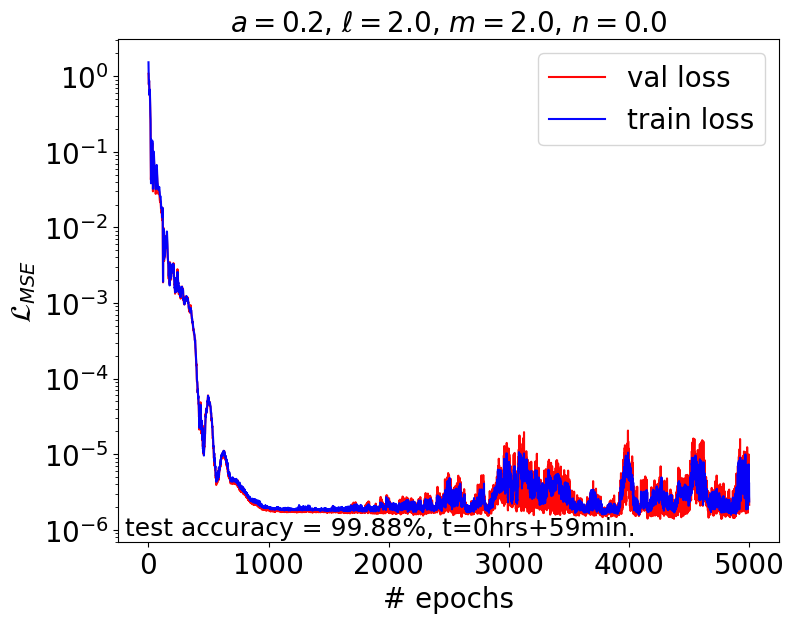

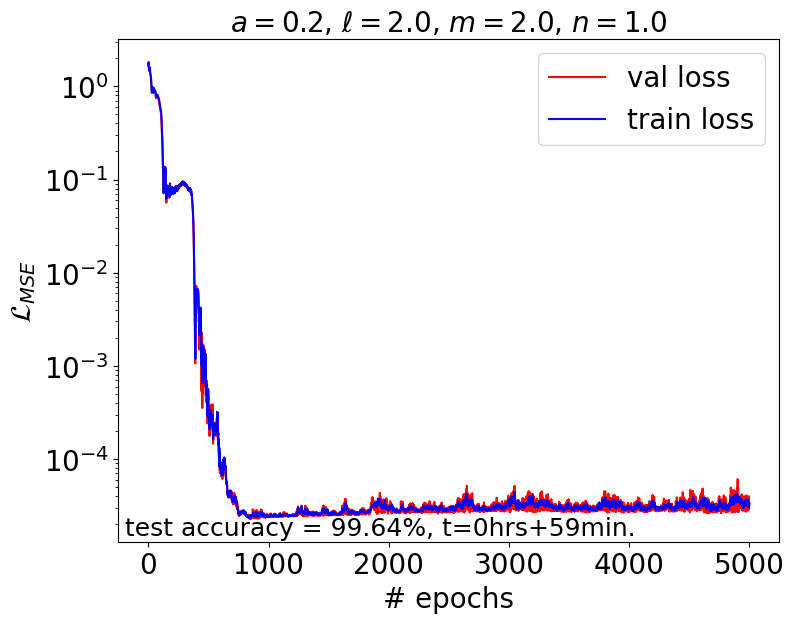

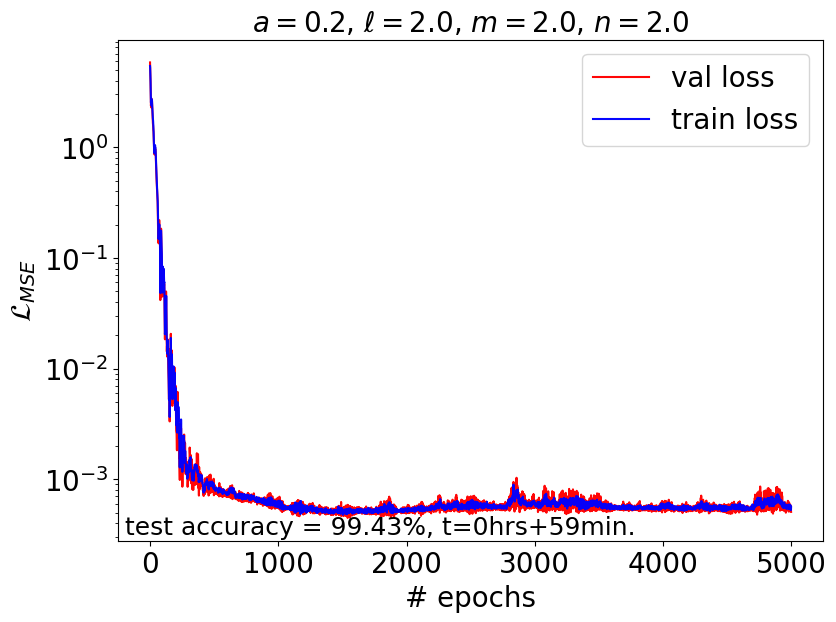

In [ ]:
plot_loss_history(train_loss_dict,
                  val_loss_dict,
                  acc_dict,
                  runtime_dict, size = 20)

In [ ]:
a = [0.0]
ell = [2.0]
m = [0.0]
n = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = dict(), dict(), dict(), dict()

for i in range(len(mode)):

    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    f_res = 'RODE_a%sell%sm%sn%s.csv'%(a, ell, m, n)
    f_res = pd.read_csv('gdrive/MyDrive/qnm_data/Kerr/'+ f_res, names=["x", "f1_res", "f2_res"])

    mask1 = f_res["f1_res"] == 'Indeterminate'
    mask2 = f_res["f2_res"] == 'Indeterminate'

    f_res.loc[mask1, "f1_res"] = 10
    f_res.loc[mask2, "f2_res"] = 10

    f_res = f_res.astype('float32').to_numpy()

    g_res = 'GODE_a%sell%sm%sn%s.csv'%(a, ell, m, n)
    g_res = pd.read_csv('gdrive/MyDrive/qnm_data/Kerr/'+ g_res, names=["u", "g1_res", "g2_res"])

    mask1 = g_res["g1_res"] == 'Indeterminate'
    mask2 = g_res["g2_res"] == 'Indeterminate'

    g_res.loc[mask1, "g1_res"] = 10
    g_res.loc[mask2, "g2_res"] = 10

    g_res = g_res.astype('float32').to_numpy()

    f1_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(f_res[:, 1:2]).mean()})
    f2_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(f_res[:, 2:3]).mean()})
    g1_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(g_res[:, 1:2]).mean()})
    g2_res_dict.update({"a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n): np.abs(g_res[:, 2:3]).mean()})


def plot_residuals_vs_overtones(f1_res_dict,
                                f2_res_dict,
                                g1_res_dict,
                                g2_res_dict,
                                size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    n_ = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    f1_res_, f2_res_, g1_res_, g2_res_ = [], [], [], []

    for i in n_:
        f1_res_.append(f1_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])
        f2_res_.append(f2_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])
        g1_res_.append(g1_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])
        g2_res_.append(g2_res_dict["a_0.0_ell_2.0_m_0.0_n_%s" %(i)])


    f, ax = plt.subplots(figsize = (8,6))
    plt.plot(n_, f1_res_, '-b', alpha=0.975, label="$Re[\Delta PDE(r)]$");
    plt.plot(n_, f2_res_, '-r', alpha=0.975, label="$Im[\Delta PDE(r)]$");
    f.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$\Delta PDE(r)$")
    plt.yscale("log")
    plt.legend(loc='upper left')
    xticks = [0, 1, 2, 3, 4, 5]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$a = 0.0$, $\ell = 2.0$, $m = 0.0$,\n $n = \{0, 1, 2, 3, 4, 5 \}$")
    plt.savefig('deltaradialpdeovertones.pdf', bbox_inches = 'tight')

    f, ax = plt.subplots(figsize = (8,6))
    plt.plot(n_, g1_res_, '-b', alpha=0.975, label="$Re[\Delta PDE(\\theta)]$");
    plt.plot(n_, g2_res_, '-r', alpha=0.975, label="$Im[\Delta PDE(\\theta)]$");
    f.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$\Delta PDE(\\theta)$")
    plt.ylim(-2e-15, 2e-15)
    plt.legend(loc='upper left')
    xticks = [0, 1, 2, 3, 4, 5]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$a = 0.0$, $\ell = 2.0$, $m = 0.0$,\n $n = \{0, 1, 2, 3, 4, 5 \}$")
    plt.savefig('deltaangularpdeovertones.pdf', bbox_inches = 'tight')


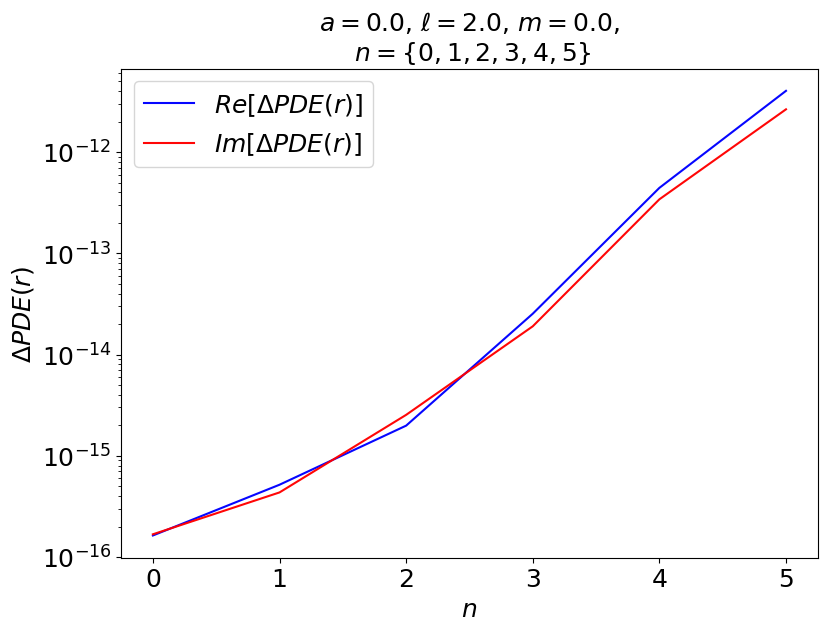

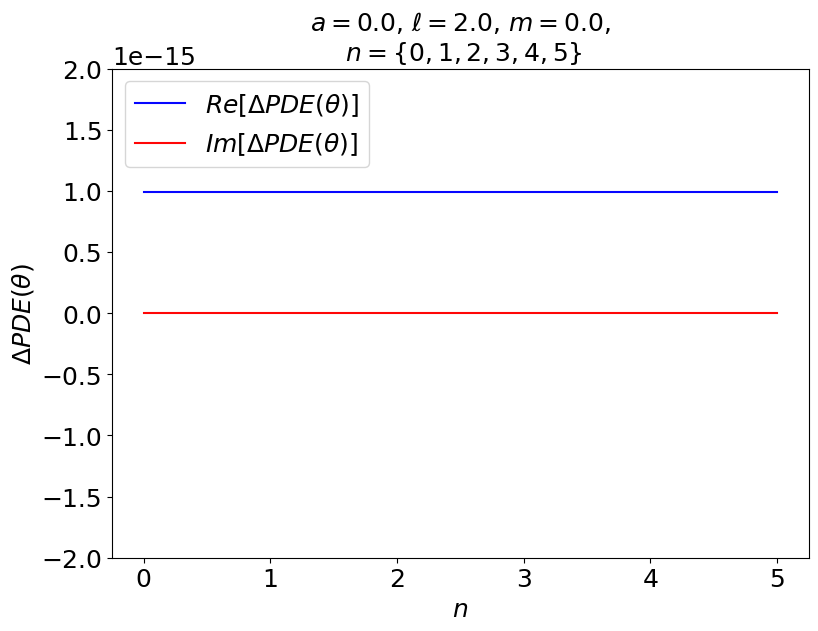

In [ ]:
plot_residuals_vs_overtones(f1_res_dict,
                            f2_res_dict,
                            g1_res_dict,
                            g2_res_dict,
                            size=18)

# extra plots

In [ ]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# just a excessively big function for adding arrows to the curve :)
def add_arrow_to_line2D(
    axes, line, arrow_locs=[0.2, 0.4, 0.6, 0.8],
    arrowstyle='-|>', arrowsize=2, transform=None):
    """
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes:
    line: Line2D object as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if not isinstance(line, mlines.Line2D):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
    }

    color = line.get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line.get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n])
        arrow_head = (np.mean(x[n:n + 2]), np.mean(y[n:n + 2]))
        p = mpatches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(p)
        arrows.append(p)
    return arrows

def kerr_2Dplots(omega1, err1, omega2, err2, A1, err3, A2, err4, omega, A, a, ell, m, n, runtime):

  size = 15
  plt.rc('xtick', labelsize=16)
  plt.rcParams.update({'font.size': 16})
  plt.rc('font', size=size)
  plt.rc('axes', titlesize=size)
  plt.rc('axes', labelsize=size)
  plt.rc('legend', fontsize=size)
  plt.rcParams['legend.loc'] = "upper right"

  # plots for the quasinormal mode frequencies

  f, ax = plt.subplots(figsize = (8,6))

  if omega1[-1] > 0 and omega2[-1] > 0:
    line1, = plt.plot(np.array(omega2)*(-1), np.array(omega1)*(1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(1)) + 0.25)

  elif omega1[-1] < 0 and omega2[-1] < 0:
    line1, = plt.plot(np.array(omega2), np.array(omega1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(-1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(-1)) + 0.25)

  elif omega1[-1] < 0 and omega2[-1] > 0:
    line1, = plt.plot(np.array(omega2)*(-1), np.array(omega1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(-1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(-1)) + 0.25)

  elif omega1[-1] > 0 and omega2[-1] < 0:
    line1, = plt.plot(np.array(omega2)*(1), np.array(omega1)*(1), zorder=1)
    add_arrow_to_line2D(ax, line1, arrow_locs=np.linspace(0, len(omega1)/9000, 100),arrowstyle='->')

    #for extra whitespace
    plt.plot(0, min(np.array(omega1)*(1)) - 0.25)
    plt.plot(0, max(np.array(omega1)*(1)) + 0.25)

  plt.scatter(omega.imag, omega.real, c="r", alpha=1, marker=r'x', label = 'CFM: $\omega_{n}$ = %.6f - %.6fj' %(abs(omega.real), abs(omega.imag)), zorder=2)

  plt.legend()
  text = 's. PINN: $\omega_{n}$ = %.6f - %.6fj (%.3f%%, %.3f%%)\n runtime %.1f minutes' %(abs(omega1[-1]), abs(omega2[-1]), err1[-1], err2[-1], round(runtime/60))
  plt.text(.01, .1, text, size= 14, ha='left', va='top', transform=ax.transAxes)
  plt.title("$s$=-2, $a$={}, $\ell$={}, $m$={}, $n$={}".format(a, ell, m, n))
  plt.ylabel('Re[$\omega_{n}$]');plt.xlabel('Im[$\omega_{n}$]')
  plt.savefig("omega_s-2.0_a{}_ell{}_m{}_n{}.pdf".format(a, ell, m, n), bbox_inches='tight')

  # plots for the separation constants

  f, ax = plt.subplots(figsize = (8,6))

  if A1[-1] > 0 and A2[-1] > 0:
    line, = plt.plot(np.array(A2), np.array(A1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)) - 0.5)
    plt.plot(0, max(np.array(A1)) + 0.5)

  elif A1[-1] < 0 and A2[-1] < 0:
    line, = plt.plot(np.array(A2)*(-1), np.array(A1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)*(-1)) - 0.5)
    plt.plot(0, max(np.array(A1)*(-1)) + 0.5)

  elif A1[-1] < 0 and A2[-1] > 0:
    line, = plt.plot(np.array(A2), np.array(A1)*(-1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)*(-1)) - 0.5)
    plt.plot(0, max(np.array(A1)*(-1)) + 0.5)

  elif A1[-1] > 0 and A2[-1] < 0:
    line, = plt.plot(np.array(A2)*(-1), np.array(A1), zorder=1)
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0, len(A1)/9000, 100),arrowstyle='->')

    #for extra white-space
    plt.plot(0, min(np.array(A1)) - 0.5)
    plt.plot(0, max(np.array(A1)) + 0.5)


  plt.scatter(A.imag, A.real, c="r", alpha=1, marker=r'x', label = 'CFM: $A_{\ell m}$ = %.6f + %.6fj' %(abs(A.real), abs(A.imag)), zorder=2)

  plt.legend()
  text = 'PINN: $A_{\ell m}$ = %.6f + %.6fj (%.3f%%, %.3f%%)\n runtime %.1f minutes' %(abs(A1[-1]), abs(A2[-1]), err3[-1], err4[-1], round(runtime/60))
  plt.text(.01, .1, text, size= 14, ha='left', va='top', transform=ax.transAxes)
  plt.title("$s$=-2, $a$={}, $\ell$={}, $m$={}, $n$={}".format(a, ell, m, n))
  plt.ylabel('Re[$A_{\ell m}$]');plt.xlabel('Im[$A_{\ell m}$]')
  plt.savefig("A_s-2.0_a{}_ell{}_m{}_n{}.pdf".format(a, ell, m, n), bbox_inches='tight')

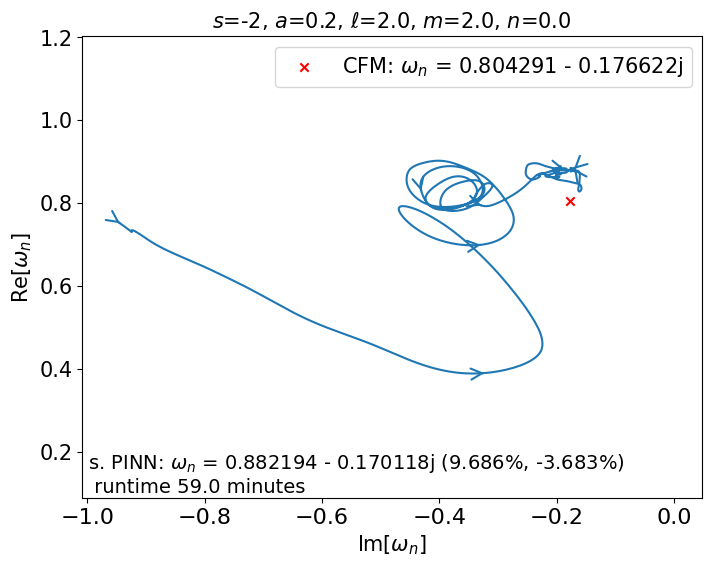

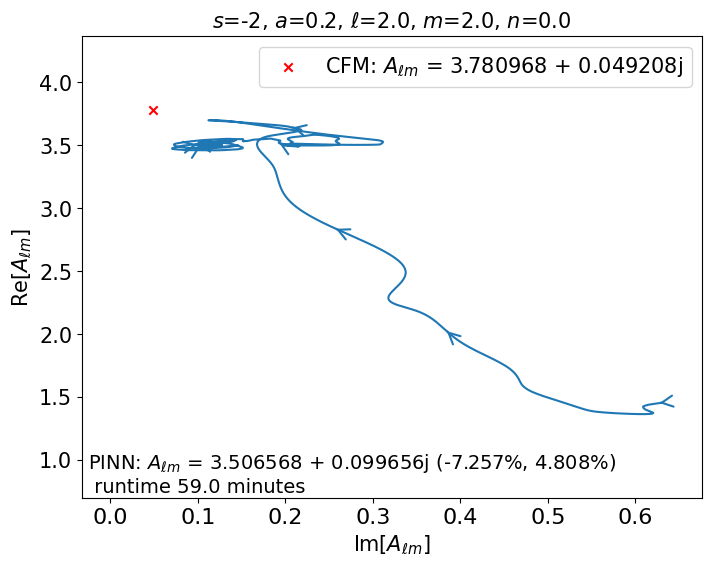

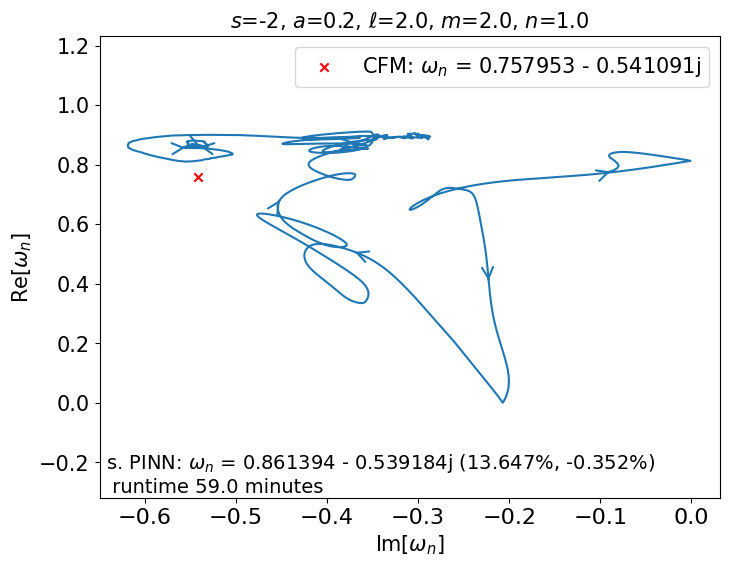

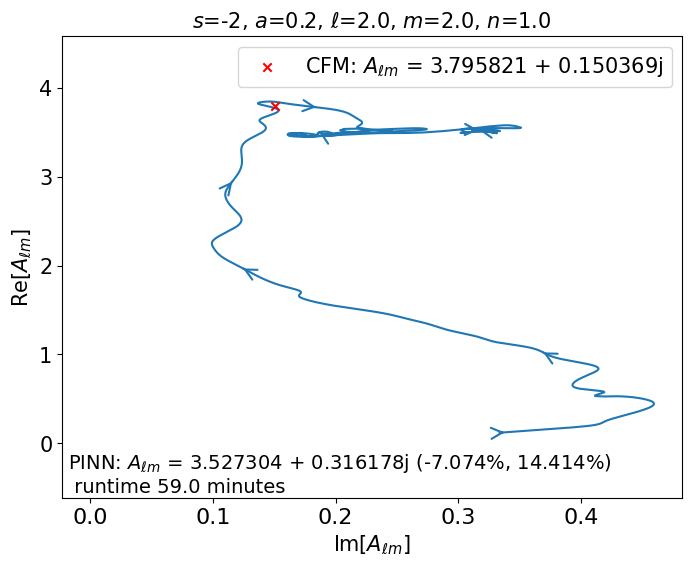

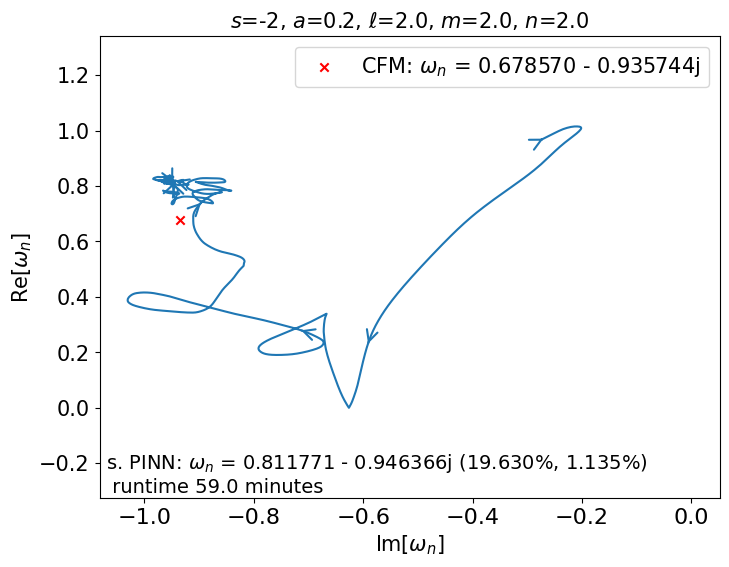

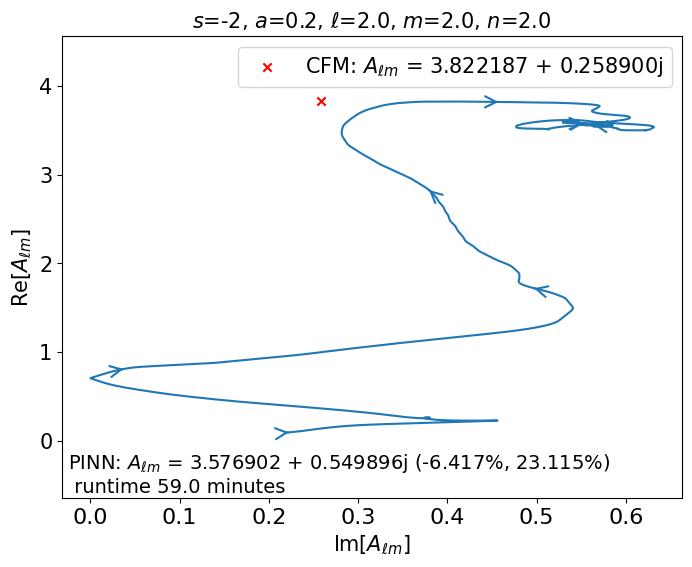

In [ ]:
s = -2
a = [0.2]
ell = [2.0]
m = [2.0]
n = [0.0, 1.0, 2.0]

mode = [dict(zip(["a", "ell", "m", "n"], [i, j, k, l])) for i, j, k, l in product(a, ell, m, n)]

for i in range(len(mode)):

    s = -2
    a = mode[i]["a"]
    ell = mode[i]["ell"]
    m = mode[i]["m"]
    n = mode[i]["n"]

    spin_sequence_slmn = qnm.modes_cache(s=int(s), l=int(ell), m=int(m), n=int(n))
    omega_, A_, _ = spin_sequence_slmn(a=a)

    kerr_2Dplots(
    omega1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    omega2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    A1_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err3_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    A2_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    err4_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)],
    omega_*2,
    A_,
    a, ell, m, n,
    runtime_dict["a_%s_ell_%s_m_%s_n_%s" %(a, ell, m, n)])